In [3]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from mlflux.datafunc import data_split_psd_rand
from mlflux.ann import RealFluxDataset

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# psd = xr.load_dataset('../../data/Processed/psd_wave.nc')
psd = xr.load_dataset('../../data/Processed/psd_coare3p0_wpapa.nc')
psd['weight'] = psd['weight']*psd.sizes['time']

/ext3/miniconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [5]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff  

class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

### Train on full dataset 

In [15]:
''' Momentum '''
from mlflux.datafunc import data_split_psd_rand
from mlflux.ann import RealFluxDataset

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

for rand_seed in (7,8,9,10):
    training_ds, validating_ds, testing_ds = data_split_psd_rand(psd, seed=rand_seed, ratio=0.2)
    
    ###### Initiate the Dataset class and use kliep weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    
    mean_value = (training_data.Y*training_data.W).mean() # scales also need to be weighted
    scale_value = ((training_data.Y - mean_value)**2*training_data.W).mean()**0.5
    
    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([mean_value]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([scale_value]).reshape(1,-1).astype('float32'))}
    
    training_paras = {'batchsize':1000, 'num_epochs':500, 'lr':5e-4, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}
    
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=True)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_weighted_rand%g" %(rand_seed))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_sensible_3layers_split%g" %(i+1))

[ 1.2231 -0.2231  0.606   0.4627  1.1327]
[ 1.0022 -0.1234  0.4975  0.3038  0.9281]
Epoch [1/500], Loss: 637.25894801
[ 1.1442 -0.1442  0.5693  0.3666  1.0277]
[ 0.952  -0.0671  0.4742  0.2242  0.8551]
Epoch [2/500], Loss: 580.03320924
[ 1.0864 -0.0864  0.5438  0.2819  0.9598]
[ 0.9183 -0.0294  0.4595  0.1535  0.8114]
Epoch [3/500], Loss: 557.86998030
[ 1.0491 -0.0491  0.5267  0.2146  0.939 ]
[ 0.8995 -0.0084  0.4507  0.0963  0.8052]
Epoch [4/500], Loss: 533.80691692
[ 1.0257 -0.0257  0.5151  0.1581  0.9359]
[0.8905 0.0018 0.446  0.0479 0.8126]
Epoch [5/500], Loss: 520.07372953
[ 1.0114 -0.0114  0.5072  0.1095  0.9507]
[0.8875 0.0051 0.4439 0.0056 0.8343]
Epoch [6/500], Loss: 509.35626151
[ 1.0042 -0.0042  0.5025  0.0729  0.9772]
[ 0.8882  0.0044  0.4439 -0.0267  0.8644]
Epoch [7/500], Loss: 502.96271130
[ 1.0005e+00 -5.4991e-04  5.0016e-01  4.2608e-02  9.9307e-01]
[ 0.8905  0.0018  0.445  -0.0531  0.8839]
Epoch [8/500], Loss: 491.51386588
[9.9901e-01 9.9123e-04 4.9909e-01 2.0577e-02 1

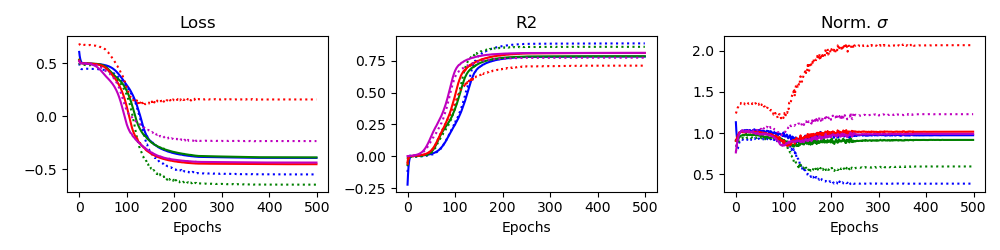

In [19]:
# Log items
# [mse.detach(), r2.detach(), LLLoss.detach(), res_mean.detach(), res_var.detach()]

import pickle as pickle
%matplotlib widget
fig, axes = plt.subplots(1, 3, figsize=[10,2.5])

for seed, color in zip([7,8,9,10], ['b','g','r','m']):
    filename = "../../saved_model/one_output_anns/Flux41_momentum_3layers_weighted_rand%g.p" %seed
    
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
                
        axes[0].plot(np.array(model.log['training_scores'])[:,2], label='Training loss', c=color)
        axes[0].plot(np.array(model.log['validating_scores'])[:,2], label='Testing loss', ls = ':', c=color)
        axes[1].plot(np.array(model.log['training_scores'])[:,1], label='Training R2', c=color)
        axes[1].plot(np.array(model.log['validating_scores'])[:,1], label='Testing R2', ls = ':', c=color)
        axes[2].plot(np.array(model.log['training_scores'])[:,-1], label='Training norm. sigma', c=color)
        axes[2].plot(np.array(model.log['validating_scores'])[:,-1], label='Testing norm. sigma', ls = ':', c=color)

for ax, title in zip(axes,['Loss', 'R2', r'Norm. $\sigma$']):
    # ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    
plt.tight_layout()

In [6]:
''' Sensible flux models '''

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

for rand_seed in (3,4,5,6):
    training_ds, validating_ds, testing_ds = data_split_psd_rand(psd, seed=rand_seed, ratio=0.2)
    
    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['hsc']
    bkeys = ['hsb']
    
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)

    mean_value = (training_data.Y*training_data.W).mean() # scales also need to be weighted
    scale_value = ((training_data.Y - mean_value)**2*training_data.W).mean()**0.5
    print('Mean %g, sigma %g' %(mean_value, scale_value))
    
    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([mean_value]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([scale_value]).reshape(1,-1).astype('float32'))}    
    
    training_paras = {'batchsize':1000, 'num_epochs':500, 'lr':5e-4, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}
    
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=True)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/one_output_anns/Flux41_sensible_3layers_weighted_rand%g" %(rand_seed))
    # model.save(fname="../../saved_model/one_output_anns/Flux51_sensible_3layers_split%g" %(i+1))

Mean -3.81339, sigma 38.7118
[9.9986e-01 1.3578e-04 5.6215e-01 4.6363e-03 1.5753e+00]
[ 1.3913e+00 -5.9116e-04  8.6269e-01  2.0772e-01  2.1926e+00]
Epoch [1/500], Loss: 573.67230199
[ 9.9982e-01  1.7893e-04  5.4912e-01 -9.7525e-03  1.5021e+00]
[1.3875 0.0021 0.8334 0.188  2.0851]
Epoch [2/500], Loss: 560.84786240
[9.9966e-01 3.3766e-04 5.4065e-01 4.2006e-03 1.4510e+00]
[ 1.3912e+00 -4.9937e-04  8.1838e-01  1.9912e-01  2.0197e+00]
Epoch [3/500], Loss: 544.14053795
[9.9957e-01 4.3356e-04 5.3179e-01 1.1608e-03 1.3927e+00]
[1.3903e+00 1.1456e-04 7.9831e-01 1.9203e-01 1.9376e+00]
Epoch [4/500], Loss: 537.55843916
[ 9.9951e-01  4.8566e-04  5.2422e-01 -6.1847e-03  1.3377e+00]
[1.3883e+00 1.5955e-03 7.7935e-01 1.8061e-01 1.8583e+00]
Epoch [5/500], Loss: 530.87511274
[ 9.9943e-01  5.7268e-04  5.1822e-01 -4.6937e-03  1.2890e+00]
[1.3886e+00 1.3368e-03 7.6483e-01 1.7873e-01 1.7913e+00]
Epoch [6/500], Loss: 524.47378522
[9.9936e-01 6.4170e-04 5.1502e-01 5.6514e-03 1.2607e+00]
[ 1.3916e+00 -8.0001e

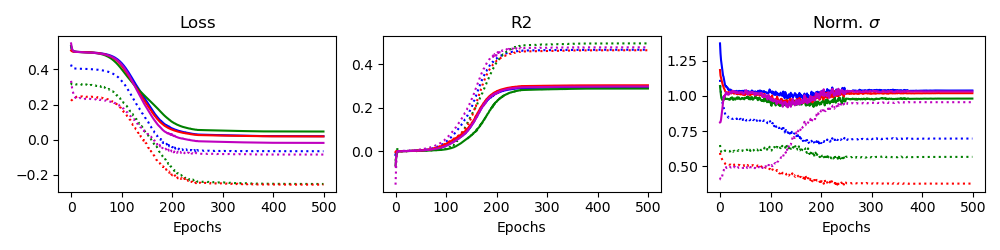

In [22]:
# Log items
# [mse.detach(), r2.detach(), LLLoss.detach(), res_mean.detach(), res_var.detach()]

import pickle as pickle
%matplotlib widget
fig, axes = plt.subplots(1, 3, figsize=[10,2.5])

for seed, color in zip([7,8,9,10], ['b','g','r','m']):
    filename = "../../saved_model/one_output_anns/Flux41_sensible_3layers_weighted_rand%g.p" %seed
    
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
                
        axes[0].plot(np.array(model.log['training_scores'])[:,2], label='Training loss', c=color)
        axes[0].plot(np.array(model.log['validating_scores'])[:,2], label='Testing loss', ls = ':', c=color)
        axes[1].plot(np.array(model.log['training_scores'])[:,1], label='Training R2', c=color)
        axes[1].plot(np.array(model.log['validating_scores'])[:,1], label='Testing R2', ls = ':', c=color)
        axes[2].plot(np.array(model.log['training_scores'])[:,-1], label='Training norm. sigma', c=color)
        axes[2].plot(np.array(model.log['validating_scores'])[:,-1], label='Testing norm. sigma', ls = ':', c=color)

for ax, title in zip(axes,['Loss', 'R2', r'Norm. $\sigma$']):
    # ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    
plt.tight_layout()

In [23]:
''' Latent flux models '''
from mlflux.datafunc import data_split_psd_rand
from mlflux.ann import RealFluxDataset

###### Network hyperparameter ######
para1 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'no'}
para2 = {'n_in':4,'n_out':1,'hidden_channels':[64,32,16],'ACTIVATION':'exponential'}
# para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

for rand_seed in (7,8,9,10):
    training_ds, validating_ds, testing_ds = data_split_psd_rand(psd, seed=rand_seed, ratio=0.2)
    
    ###### Initiate the Dataset class and use default weighting ######
    ikeys = ['U','tsea','tair','rh']
    # ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['hlc']
    bkeys = ['hlb']
    
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys)
    
    mean_value = (training_data.Y*training_data.W).mean() # scales also need to be weighted
    scale_value = ((training_data.Y - mean_value)**2*training_data.W).mean()**0.5
    print('Mean %g, sigma %g' %(mean_value, scale_value))
    
    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    
    # Changed where the scaling numbers are specified
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([mean_value]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([scale_value]).reshape(1,-1).astype('float32'))}    
    
    training_paras = {'batchsize':1000, 'num_epochs':500, 'lr':5e-4, 'gamma':0.2,
                      'EARLYSTOPPING':False, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':100}
    
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=True)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    model.save(fname="../../saved_model/one_output_anns/Flux41_latent_3layers_weighted_rand%g" %(rand_seed))

Mean -46.0023, sigma 61.0391
[ 0.9985  0.0015  0.5057 -0.0018  0.8731]
[ 1.1098 -0.0045  0.5435  0.1273  0.9704]
Epoch [1/500], Loss: 507.58982142
[0.9983 0.0017 0.5011 0.0139 0.9381]
[ 1.1141 -0.0084  0.5504  0.1452  1.0469]
Epoch [2/500], Loss: 502.35337385
[9.9772e-01 2.2836e-03 4.9906e-01 7.8895e-05 9.8246e-01]
[ 1.1099 -0.0046  0.5531  0.1367  1.0929]
Epoch [3/500], Loss: 497.92313930
[0.9973 0.0027 0.4982 0.003  1.0219]
[ 1.1104 -0.0051  0.5582  0.1418  1.1377]
Epoch [4/500], Loss: 494.62731549
[0.9969 0.0031 0.4979 0.0013 1.0421]
[ 1.1097 -0.0045  0.5606  0.1418  1.16  ]
Epoch [5/500], Loss: 496.91062662
[ 0.9964  0.0036  0.4976 -0.0025  1.0403]
[ 1.1084 -0.0033  0.5597  0.1385  1.1572]
Epoch [6/500], Loss: 496.74158776
[0.9959 0.0041 0.4973 0.0054 1.0339]
[ 1.1102 -0.0049  0.5597  0.1447  1.1525]
Epoch [7/500], Loss: 494.28877201
[0.9954 0.0046 0.4969 0.0035 1.0322]
[ 1.1094 -0.0042  0.5591  0.1431  1.1503]
Epoch [8/500], Loss: 494.44145071
[0.9949 0.0051 0.4966 0.0118 1.0309]


{'mean': tensor([[-47.7078]]), 'scale': tensor([[62.5081]])}
{'mean': tensor([[-46.0023]]), 'scale': tensor([[61.0391]])}
{'mean': tensor([[-46.0231]]), 'scale': tensor([[61.4966]])}
{'mean': tensor([[-46.7609]]), 'scale': tensor([[63.3425]])}


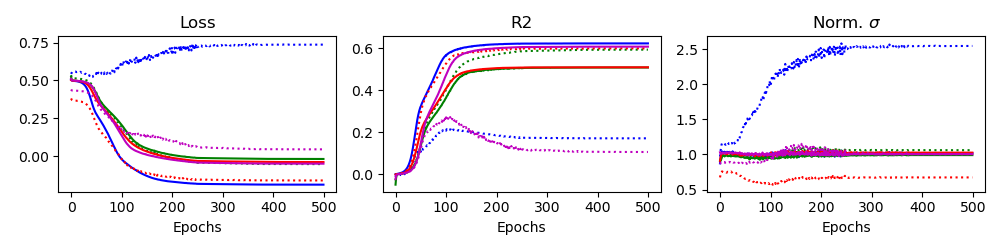

In [29]:
# Log items
# [mse.detach(), r2.detach(), LLLoss.detach(), res_mean.detach(), res_var.detach()]

import pickle as pickle
%matplotlib widget
fig, axes = plt.subplots(1, 3, figsize=[10,2.5])

for seed, color in zip([7,8,9,10], ['b','g','r','m']):
    filename = "../../saved_model/one_output_anns/Flux41_latent_3layers_weighted_rand%g.p" %seed
    print(model.Yscale)
    
    with open(filename, "rb") as input_file:
        model = pickle.load(input_file)
                
        axes[0].plot(np.array(model.log['training_scores'])[:,2], label='Training loss', c=color)
        axes[0].plot(np.array(model.log['validating_scores'])[:,2], label='Testing loss', ls = ':', c=color)
        axes[1].plot(np.array(model.log['training_scores'])[:,1], label='Training R2', c=color)
        axes[1].plot(np.array(model.log['validating_scores'])[:,1], label='Testing R2', ls = ':', c=color)
        axes[2].plot(np.array(model.log['training_scores'])[:,-1], label='Training norm. sigma', c=color)
        axes[2].plot(np.array(model.log['validating_scores'])[:,-1], label='Testing norm. sigma', ls = ':', c=color)

for ax, title in zip(axes,['Loss', 'R2', r'Norm. $\sigma$']):
    # ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    
plt.tight_layout()

In [ ]:
filename = "../../saved_model/one_output_anns/
models = ['Flux41_momentum_3layers_weighted_rand10.p', 'Flux41_sensible_3layers_weighted_rand10.p', 'Flux41_latent_3layers_weighted_rand8.p']

### Train with split ensemble

In [ ]:
# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [ ]:
''' Momentum flux models '''
momentum_model_ensem = []

###### Network hyperparameter ######
# para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    # ikeys = ['U','tsea','tair','rh']
    ikeys = ['U','tsea','tair','rh','qair']
    okeys = ['taucx']
    bkeys = ['taubx']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}   
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([0.1]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data, validating_data, training_paras, VERBOSE=False)
    momentum_model_ensem.append(model)
    
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_momentum_3layers_split%g" %(i+1))
    model.save(fname="../../saved_model/one_output_anns/Flux51_momentum_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 228 epochs.
training took 45.97 seconds, loss at last epoch -51.6604
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 139 epochs.
training took 33.14 seconds, loss at last epoch -52.7231
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 217 epochs.
training took 45.51 seconds, loss at last epoch -61.7088
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 271 epochs.
training took 68.93 seconds, loss at last epoch -58.2599
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 147 epochs.
training took 35.59 seconds, loss at last epoch -41.9575
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [5]:
''' Sensible flux models '''
Qs_model_ensem = []

###### Network hyperparameter ######
# para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    # ikeys = ['U','tsea','tair','rh']
    ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['hsc']
    bkeys = ['hsb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([-8]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20]).reshape(1,-1).astype('float32'))}
    model.datasplit = split
    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':2e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Qs_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_sensible_3layers_split%g" %(i+1))
    model.save(fname="../../saved_model/one_output_anns/Flux51_sensible_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 427 epochs.
training took 94.19 seconds, loss at last epoch -30.0759
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 61 epochs.
training took 15.52 seconds, loss at last epoch -18.2710
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 137 epochs.
training took 30.84 seconds, loss at last epoch 19.6032
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 121 epochs.
training took 33.36 seconds, loss at last epoch 8.3997
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 266 epochs.
training took 70.94 seconds, loss at last epoch -13.2483
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 104 epochs.
training took 29.56 seconds, loss at last epoch 5.7413


In [6]:
''' Latent flux models '''
Ql_model_ensem = []

###### Network hyperparameter ######
# para1 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
# para2 = {'n_in':4,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}
para1 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'no'}
para2 = {'n_in':5,'n_out':1,'hidden_channels':[16,32,16],'ACTIVATION':'exponential'}

###### Use default weight function ######
# from mlflux.ann import sample_weights
###### Or define a new one ######
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

for i, split in enumerate(split_ensem):
    training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split, PLOT=False, XVIS='samples')

    ###### Initiate the Dataset class and use default weighting ######
    # ikeys = ['U','tsea','tair','rh']
    ikeys = ['U','tsea','tair','rh', 'qair']
    okeys = ['hlc']
    bkeys = ['hlb']
    training_data = RealFluxDataset(training_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    validating_data = RealFluxDataset(validating_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)
    testing_data = RealFluxDataset(testing_ds, input_keys=ikeys, output_keys=okeys, bulk_keys=bkeys, weightfunc=sample_weights)

    model = Fluxdiff({'mean_ann_para':para1, 'var_ann_para':para2})
    # Changed where the scaling numbers are specified
    # model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0]).reshape(1,-1).astype('float32')),
    #                 'scale':torch.tensor(np.array([20,20,20,100]).reshape(1,-1).astype('float32'))}      
    model.Xscale = {'mean':torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))}      
    model.Yscale = {'mean':torch.tensor(np.array([-90]).reshape(1,-1).astype('float32')),
                    'scale':torch.tensor(np.array([50.]).reshape(1,-1).astype('float32'))}
    model.datasplit = split

    training_paras = {'batchsize':100, 'num_epochs':1000, 'lr':1e-3, 'gamma':0.2,
                      'EARLYSTOPPING':True, 'patience':20, 'factor':0.5, 'max_epochs_without_improvement':60}
    log = model.fit(training_data,validating_data,training_paras,VERBOSE=False)
    Ql_model_ensem.append(model)
    # Later we can pick one before saving but since files are pretty small they are ok 
    # model.save(fname="../../saved_model/one_output_anns/Flux41_latent_3layers_split%g" %(i+1))
    model.save(fname="../../saved_model/one_output_anns/Flux51_latent_3layers_split%g" %(i+1))

Training samples: 7005
Validating samples: 3068
Testing samples: 3068


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 101 epochs.
training took 21.47 seconds, loss at last epoch 5.2359
Training samples: 8463
Validating samples: 1610
Testing samples: 1610


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 75 epochs.
training took 19.08 seconds, loss at last epoch 4.7212
Training samples: 7424
Validating samples: 2649
Testing samples: 2649


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 72 epochs.
training took 16.13 seconds, loss at last epoch 6.5687
Training samples: 9194
Validating samples: 879
Testing samples: 879


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 96 epochs.
training took 26.56 seconds, loss at last epoch 0.5867
Training samples: 8826
Validating samples: 1247
Testing samples: 1247


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 169 epochs.
training took 44.96 seconds, loss at last epoch -6.9173
Training samples: 9453
Validating samples: 620
Testing samples: 620


/ext3/miniconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping triggered after 83 epochs.
training took 23.59 seconds, loss at last epoch 3.1527


In [9]:
''' Testing '''
def mse_r2(ypred, ytruth):
    ''' Assuming Nsample*Nfeatures. Change this to just keeping the last axis. '''
    mse = np.average((ypred-ytruth)**2, axis=0)
    r2 = 1 - np.average((ypred-ytruth)**2, axis=0)/np.var(ytruth, axis=0)
    return (mse,r2)

def evaluate_over_splits (model, keys):
    nn_r2_splits = []; bulk_r2_splits = []
    for i in range(6):
        training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[i], PLOT=False, XVIS='samples', VERBOSE=False)
        vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
        scores = model.metrics(vd.X, vd.Y)    
        bulk_mse, bulk_r2 = mse_r2(vd.Bulk.detach().numpy(), vd.Y.detach().numpy())
        nn_r2_splits.append(scores['r2']); bulk_r2_splits.append(bulk_r2)
    return (np.array(nn_r2_splits).squeeze(), np.array(bulk_r2_splits).squeeze())
        # print('NN r2 %.4f, bulk r2 %.4f' %(scores['r2'], bulk_r2))

In [16]:
''' Momentum flux '''
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
for model in momentum_model_ensem:
    model.nn_taux_r2_splits, model.bulk_taux_r2_splits = evaluate_over_splits(model, keys)
    print(model.nn_taux_r2_splits, model.bulk_taux_r2_splits)

''' Sensible heat '''
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
for model in Qs_model_ensem:
    model.nn_hs_r2_splits, model.bulk_hs_r2_splits = evaluate_over_splits(model, keys)
    print(model.nn_hs_r2_splits, model.bulk_hs_r2_splits)

''' Latent heat '''
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
for model in Ql_model_ensem:
    model.nn_hl_r2_splits, model.bulk_hl_r2_splits = evaluate_over_splits(model, keys)
    print(model.nn_hl_r2_splits, model.bulk_hl_r2_splits)

[0.85082805 0.37794286 0.549187   0.87614113 0.92277753 0.8145199 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8616094  0.38191324 0.5285684  0.8649068  0.9233487  0.81538844] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8479959  0.38508874 0.52369714 0.85217696 0.9146648  0.8170444 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8574308  0.39348173 0.5419674  0.85796857 0.91068804 0.81408733] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8400941  0.4065535  0.552574   0.84618413 0.8641637  0.8163718 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.8602823  0.392492   0.5427512  0.86315197 0.9191645  0.8123565 ] [0.871802   0.37037218 0.48821545 0.8757325  0.92528903 0.8058857 ]
[0.59749126 0.0185234  0.37422    0.8023492  0.48987597 0.8316152 ] [0.6199423  0.01651239 0.37613034 0.7691618  0.44552934 0.7945473 ]
[0.5827594  0.01106697 0.35350847 0.5898787  0.4

In [20]:
model.bulk_hl_r2_splits

array([0.7058047 , 0.51981413, 0.42166954, 0.64867926, 0.32681125,
       0.8812301 ], dtype=float32)

[0.85082805 0.8616094  0.8479959  0.8574308  0.8400941  0.8602823 ]
[0.37794286 0.38191324 0.38508874 0.39348173 0.4065535  0.392492  ]
[0.549187   0.5285684  0.52369714 0.5419674  0.552574   0.5427512 ]
[0.87614113 0.8649068  0.85217696 0.85796857 0.84618413 0.86315197]
[0.92277753 0.9233487  0.9146648  0.91068804 0.8641637  0.9191645 ]
[0.8145199  0.81538844 0.8170444  0.81408733 0.8163718  0.8123565 ]


Text(0.5, 1.0, 'Momentum flux $\\tau_x$')

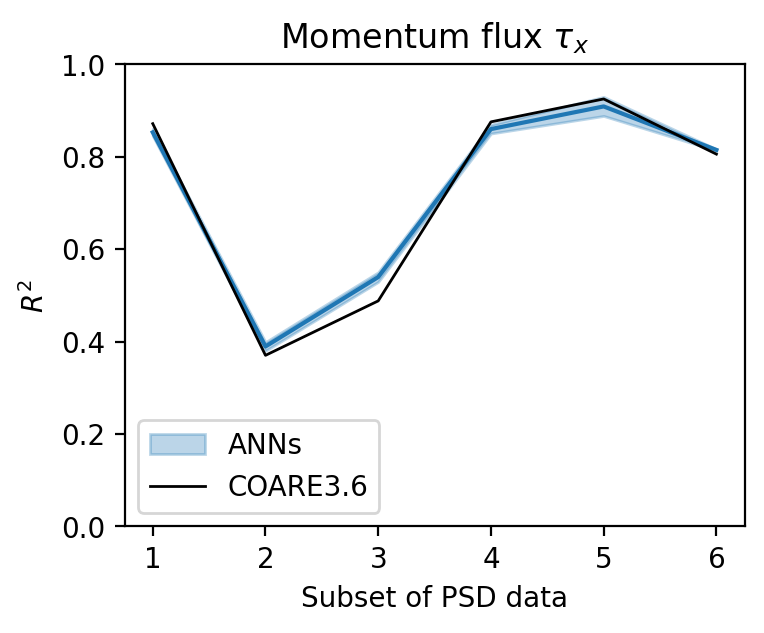

In [22]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_taux_r2_splits[i] for model in momentum_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
    # plt.plot(model.nn_r2_splits,'.-')
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, momentum_model_ensem[0].bulk_taux_r2_splits, '-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Momentum flux $\tau_x$')

[0.59749126 0.5827594  0.6275765  0.6360412  0.6225828  0.6310206 ]
[0.0185234  0.01106697 0.01551026 0.02278608 0.01871973 0.01935017]
[0.37422    0.35350847 0.31677204 0.36549455 0.3622628  0.36189234]
[0.8023492  0.5898787  0.6148717  0.71873736 0.6245085  0.6384126 ]
[0.48987597 0.47423935 0.47961944 0.4797883  0.4713872  0.4803716 ]
[0.8316152  0.6809113  0.68542516 0.8103204  0.6924834  0.6879866 ]


Text(0.5, 1.0, 'Sensible heat flux $Q_s$')

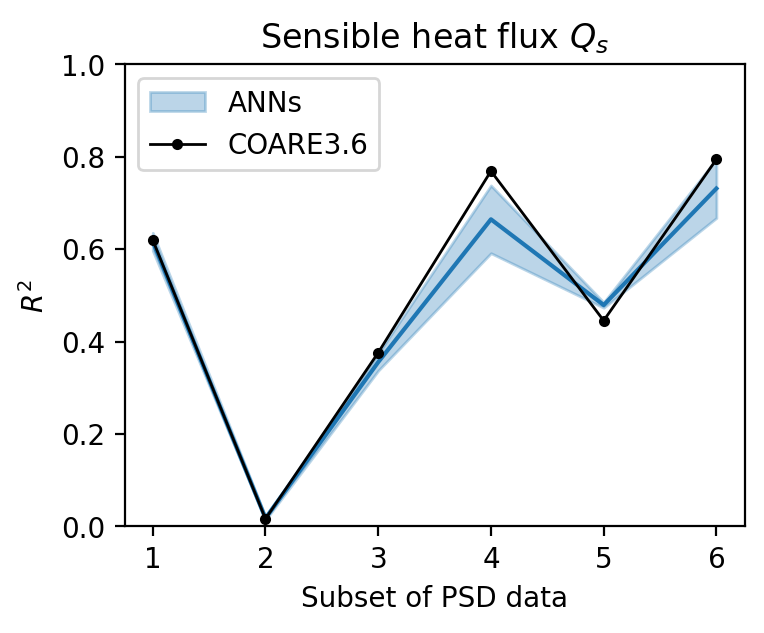

In [21]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_hs_r2_splits[i] for model in Qs_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
    # plt.plot(model.nn_r2_splits,'.-')
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, Qs_model_ensem[0].bulk_hs_r2_splits, '.-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Sensible heat flux $Q_s$')

[0.6449858  0.6866894  0.68435645 0.64052    0.69565386 0.6425775 ]
[0.6058314 0.602359  0.5905018 0.6013402 0.601493  0.6052996]
[0.4389218  0.44170487 0.2958678  0.43613273 0.438865   0.44141787]
[0.54527855 0.62505865 0.6375531  0.3697902  0.65302956 0.45727754]
[0.40608853 0.4037115  0.38909453 0.40402848 0.39618826 0.4064451 ]
[0.5853437  0.67276955 0.75066155 0.43295616 0.7308068  0.4986927 ]


Text(0.5, 1.0, 'Latent heat flux $Q_L$')

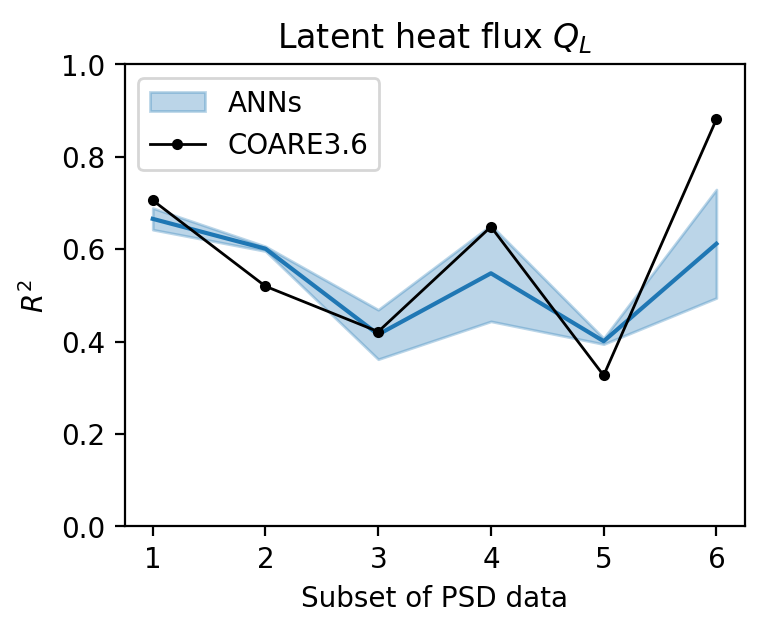

In [23]:
means = []; stds = []
for i in range(len(split_ensem)):
    r2s = np.array([model.nn_hl_r2_splits[i] for model in Ql_model_ensem])
    means.append(np.average(r2s))
    stds.append(np.std(r2s))   
    print(r2s)
means = np.array(means); stds = np.array(stds)
x = [1,2,3,4,5,6]

fig = plt.figure(figsize=[4,3],dpi=200)
plt.plot(x, means)
plt.fill_between(x, means-stds, means+stds, color='C0', alpha=0.3, label='ANNs')
plt.plot(x, Ql_model_ensem[0].bulk_hl_r2_splits, '.-', c='k', label='COARE3.6', lw=1)
plt.ylim([0.,1]); 
plt.xlabel('Subset of PSD data'); plt.ylabel('$R^2$') 
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.legend(); plt.title(r'Latent heat flux $Q_L$')

(0.0, 1.0)

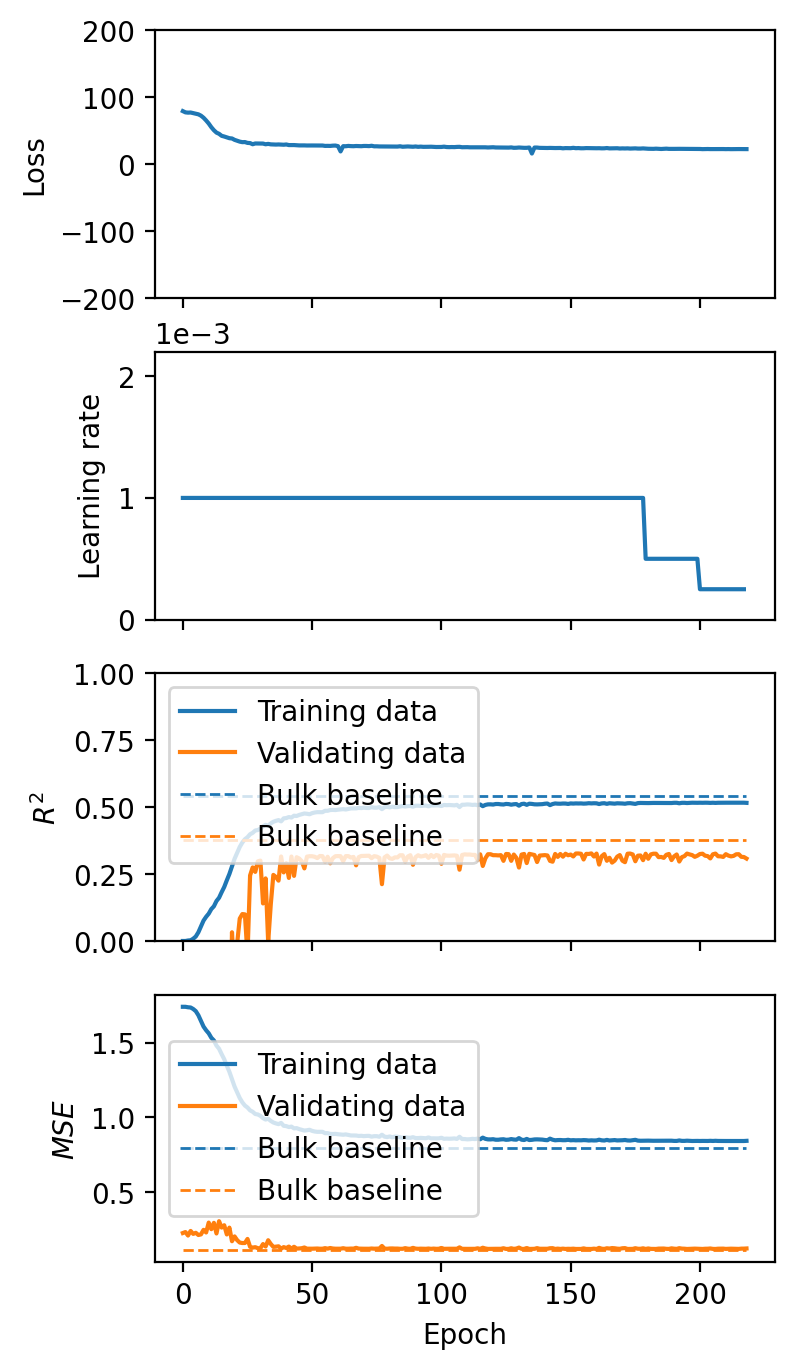

In [25]:
from mlflux.plotting import vis_training

model = Qs_model_ensem[2]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=model.datasplit, PLOT=False, XVIS='samples', VERBOSE=False)
training_data = RealFluxDataset(training_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

fig, axes = vis_training (model.log)
axes[0].set_ylim([-200,200])
axes[1].set_ylim([0,0.0022])

nepoch = len(model.log['LLLoss'])
Yscale = model.Yscale['scale'].numpy().squeeze()

bulk_mse, bulk_r2 = mse_r2(training_data.Bulk.detach().numpy(), training_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C0', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C0', label='Bulk baseline', lw=1)
bulk_mse, bulk_r2 = mse_r2(validating_data.Bulk.detach().numpy(), validating_data.Y.detach().numpy())
axes[2].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_r2, '--', c='C1', label='Bulk baseline', lw=1)
axes[3].plot(np.arange(0,nepoch),np.ones(nepoch)*bulk_mse/Yscale**2, '--', c='C1', label='Bulk baseline', lw=1)
axes[2].legend()
axes[3].legend()
axes[2].set_ylim([0,1])
# axes[3].set_ylim([0,0.6])

### Plot predictions

In [28]:
def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Measurements')
    ax.plot(X,Y_pred, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='ANN Prediction (mean)')
    if LEGEND:
        ax.legend(fancybox=False)

Text(0, 0.5, 'Momentum flux $\\tau_x \\; [N/m^2]$')

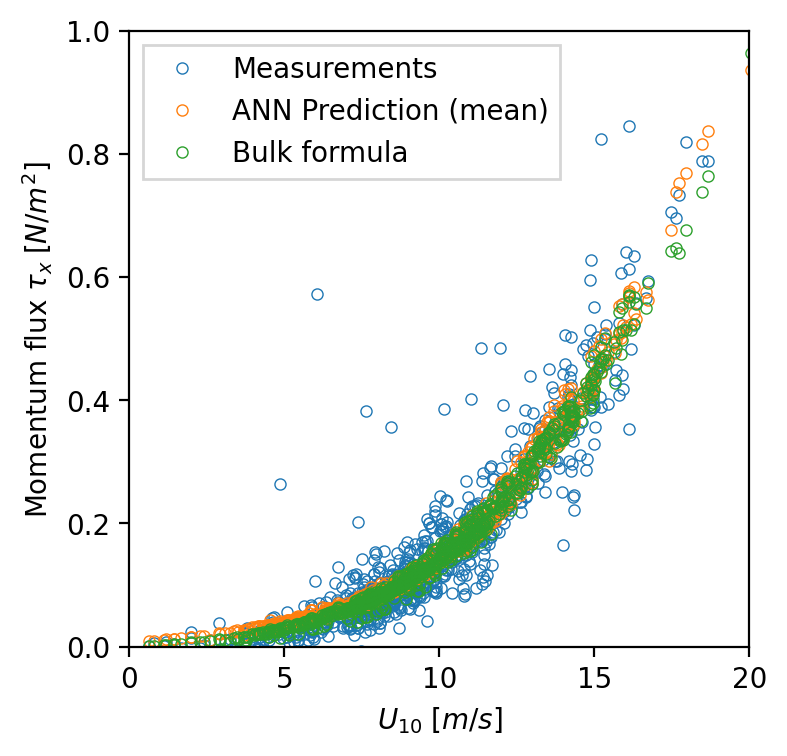

In [55]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = momentum_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,0], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,0], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([0,1]); ax.set_xlim([0,20])
ax.set_xlabel('$U_{10} \; [m/s]$'); ax.set_ylabel(r'Momentum flux $\tau_x \; [N/m^2]$')

Text(0, 0.5, 'Sensible heat flux $Q_s \\; [W/m^2]$')

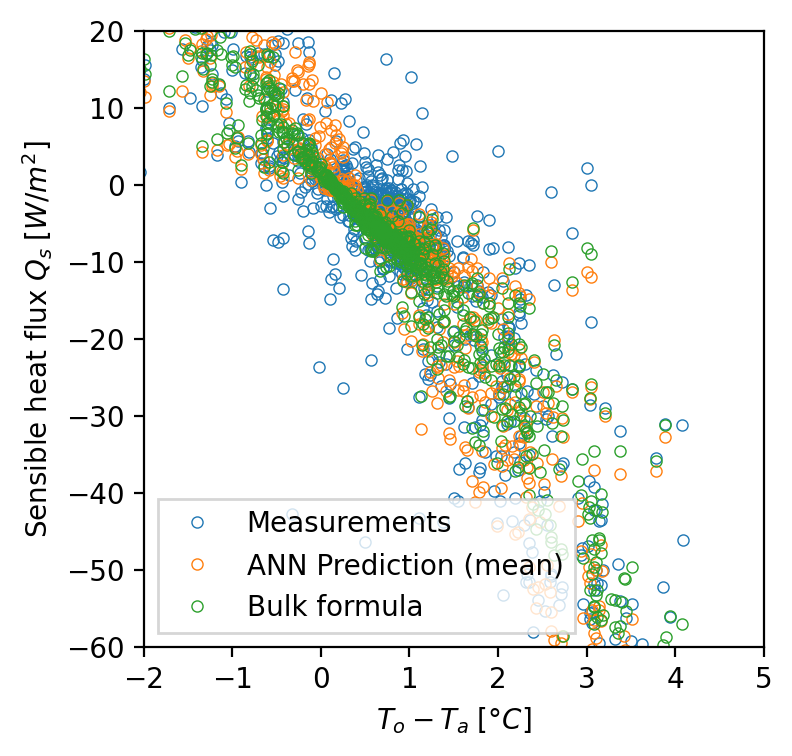

In [54]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = Qs_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-60,20]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a \; [\degree C]$'); ax.set_ylabel('Sensible heat flux $Q_s \; [W/m^2]$')

Text(0, 0.5, 'Latent heat flux $Q_L \\; [W/m^2]$')

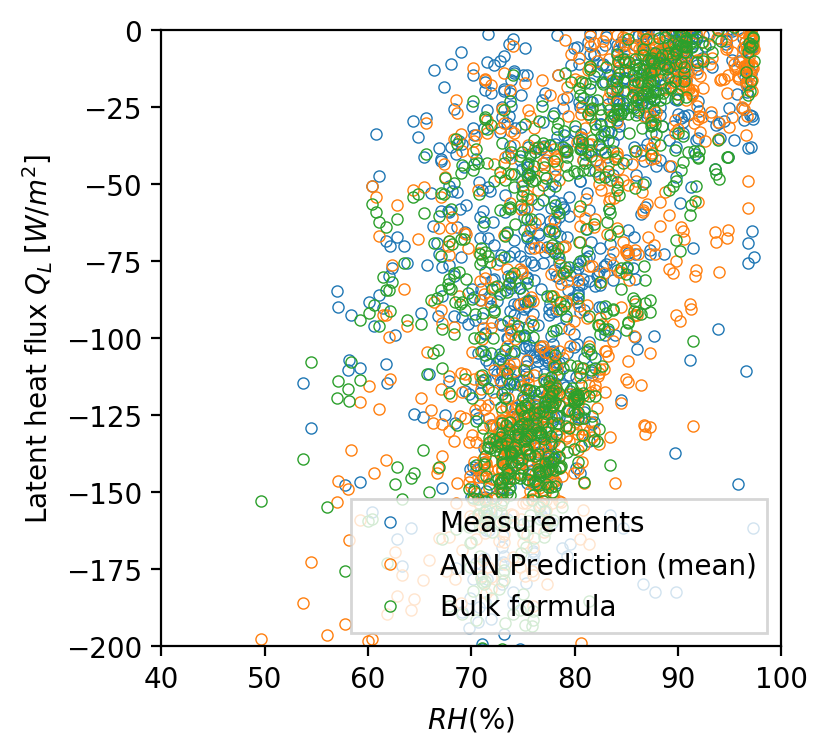

In [53]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

model = Ql_model_ensem[0]
training_ds, validating_ds, testing_ds = data_split_psd(psd, split=split_ensem[3], PLOT=False, XVIS='samples', VERBOSE=False)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(validating_ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,3], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,3], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-200,0]); ax.set_xlim([40,100])
ax.set_xlabel(r'$RH(\%)$')
ax.set_ylabel('Latent heat flux $Q_L \; [W/m^2]$')